# Predicción de sueldo bruto basado en liquidaciones de nómina históricas en GesDocument para Pymes usando Machine Learning

### Este algoritmo tiene como objetivo realizar la predicción de sueldo bruto para los clientes categorizados como Pymes en GesDocument, esto de acuerdo con los movimientos de nómina que se registran periódicamente en la liquidación de la nómina para cada uno de estos.




### Preparando el entorno

In [4]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

df = spark.sql('select "Spark OK" as Status')
df.show()

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark.sql.functions as f

+--------+
|  Status|
+--------+
|Spark OK|
+--------+



## Carga de datos


El fichero con el que vamos a trabajar contiene datos reales de nóminas liquidadas en el año 2022 y 2023 de las Pymes.

Los datos que contiene este fichero son: Código de Empresa, Año, Total de Empleados en la Nómina, Cantidad de Altas del Mes, Total Bruto de Todos los Empleados y Total Bruto Exclusivo de las Altas del Mes.

In [5]:
#filePath = "nominas2.csv"
filePath = "nominas3.csv"
df1 = spark.read.format("csv").option("header","true").option("delimiter", ";").option("inferSchema", "true").load(filePath)

In [6]:
##To Do
#dfmoda = df.select("CodigoEmpresa", "EmpleadosTotal").where("CodigoEmpresa = 47535").distinct().show()

df = df1.filter(df1.Anio == 2023).filter(df1.Mes >= 7)

## Preprocesado de Datos
En esta fase nos interesa mucho explorar del conjunto de datos cuales de estos tienen sentido para el entrenamiento de un modelo y/o sí hay que aplicar borrados, reemplazos, etc.

In [7]:
df.show()

+-------------+----+---+--------------+-----------+---------------+---------------+
|CodigoEmpresa|Anio|Mes|EmpleadosTotal|AltasDelMes|TotalBrutoTodos|TotalBrutoAltas|
+-------------+----+---+--------------+-----------+---------------+---------------+
|        47674|2023|  9|             6|          0|       13893.57|            0.0|
|        47515|2023|  9|             5|          1|        7065.04|         720.37|
|        38600|2023|  9|             1|          0|        5508.23|            0.0|
|        47686|2023|  9|            14|          2|       33139.84|         1531.5|
|        42508|2023|  9|             1|          0|         8000.0|            0.0|
|        23095|2023|  9|            18|          0|       68585.64|            0.0|
|        46615|2023|  9|             5|          0|        7556.03|            0.0|
|        42736|2023|  9|             2|          0|        5899.26|            0.0|
|        44863|2023|  9|             2|          0|        1286.25|         

In [8]:
df.printSchema()

root
 |-- CodigoEmpresa: integer (nullable = true)
 |-- Anio: integer (nullable = true)
 |-- Mes: integer (nullable = true)
 |-- EmpleadosTotal: integer (nullable = true)
 |-- AltasDelMes: integer (nullable = true)
 |-- TotalBrutoTodos: double (nullable = true)
 |-- TotalBrutoAltas: double (nullable = true)



## Cantidad de Registros

In [9]:
df.count()

555

## Preprocesamiento. 

### Análisis de nulos

__a)__ Estudiar el número de nulos de la primera columna. Calcular el porcentaje de nulos con respecto al número total de registros.

In [11]:
print(f"{round(df.filter(df['CodigoEmpresa'].isNull()).count() / df.count() * 100, 2)}%")

0.0%


__b)__ Estudiar el número de nulos de todas las columnas. Encontramos el porcentaje de nulos en cada una de las columnas del dataframe recibido como parámetro de entrada:

In [12]:
def estudiar_nulos(df):
    total = df.count()
    return {col: round(df.filter(df[col].isNull()).count() / total * 100, 2)
            for col in df.columns}

nulos = estudiar_nulos(df)
print(nulos)

{'CodigoEmpresa': 0.0, 'Anio': 0.0, 'Mes': 0.0, 'EmpleadosTotal': 0.0, 'AltasDelMes': 0.0, 'TotalBrutoTodos': 0.0, 'TotalBrutoAltas': 0.0}


__c)__ Estudiar el número de ceros de todas las columnas. Encontramos el porcentaje de ceros en cada una de las columnas del dataframe recibido como parámetro de entrada:

In [13]:
def estudiar_ceros(df):
    total = df.count()
    return {col: round(df.filter(df[col] < 1).count() / total * 100, 2)
            for col in df.columns}

ceros = estudiar_ceros(df)
print(ceros)

{'CodigoEmpresa': 0.0, 'Anio': 0.0, 'Mes': 0.0, 'EmpleadosTotal': 0.0, 'AltasDelMes': 91.53, 'TotalBrutoTodos': 1.8, 'TotalBrutoAltas': 92.79}


## Preparar Vector de Características

### Regresión lineal

__a) Preparar los datos para el modelo.__ Crear una función llamada `prepara_datos` que permita transformar el dataframe `df` para que todas columnas salvo las que no nos interesan (`TotalBrutoTodos`, `TotalBrutoAltas`) estén juntas en un vector con nombre `features`. La función devuelve como resultado un nuevo dataframe. Llamar al nuevo dataframe `dataprep`. Para ello usamos `Vector Assembler`.

In [16]:
from pyspark.ml.feature import VectorAssembler

def prepara_datos(df):
    #cols = [col for col in df.columns if (col != 'TotalBrutoTodos' and col != 'TotalBrutoAltas' and col != 'Anio' and col != 'Mes' and col != 'AltasDelMes' and col != 'AltasDelMes')]
    cols = [col for col in df.columns if (col != 'EmpleadosTotal' and col != 'TotalBrutoAltas' and col != 'Mes')]
    assembler = VectorAssembler(inputCols = cols, outputCol ='features')
    output =  assembler.transform(df)
    transformed = output.select('features', 'EmpleadosTotal')
    return transformed

In [17]:
# Probando la función:
dataprep = prepara_datos(df)
dataprep.show(10)

+--------------------+--------------+
|            features|EmpleadosTotal|
+--------------------+--------------+
|[47674.0,2023.0,0...|             6|
|[47515.0,2023.0,1...|             5|
|[38600.0,2023.0,0...|             1|
|[47686.0,2023.0,2...|            14|
|[42508.0,2023.0,0...|             1|
|[23095.0,2023.0,0...|            18|
|[46615.0,2023.0,0...|             5|
|[42736.0,2023.0,0...|             2|
|[44863.0,2023.0,0...|             2|
|[37902.0,2023.0,0...|             1|
+--------------------+--------------+
only showing top 10 rows



__b) Crear un modelo de Regresión Lineal.__ Para ello:

* Dividir `dataprep` en conjunto de entrenamiento (60%) y de test (40%)
* Declarar un método de regresión lineal sin parámetros
* Entrenar el método para obtener el modelo
* Aplicar el modelo tanto al train como al test. En el primer caso las predicciones se llamarán train_pred, y en el segundo test_pred
* Declarar evaluadores para RMSE y para R2
* Mostrar ambas métricas sobre train_pred y sobre test_pred

In [18]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Entrenamiento y test
train, test = dataprep.randomSplit([0.6, 0.4])
print(f"Número de filas para entrenamiento: {train.count()}")
print(f"Número de filas para test: {test.count()}")

# Método
regressor = LinearRegression(featuresCol='features', labelCol='EmpleadosTotal')

# Entrenamos el modelo
model = regressor.fit(train)

# Predicción
train_pred = model.transform(train)
test_pred = model.transform(test)

print("Train prediction:")
train_pred.show(20)
print("Test prediction:")
test_pred.show(20)

# Evaluación (varianza)
evaluator_rmse = RegressionEvaluator(predictionCol='prediction', labelCol='EmpleadosTotal',
                                     metricName='rmse')
rmse_train = evaluator_rmse.evaluate(train_pred)
rmse_test = evaluator_rmse.evaluate(test_pred)

evaluator_r2 = RegressionEvaluator(predictionCol='prediction', labelCol='EmpleadosTotal',
                                   metricName='r2')
r2_train = evaluator_r2.evaluate(train_pred)
r2_test = evaluator_r2.evaluate(test_pred)

print(f"Train RMSE: {rmse_train}")
print(f"Train R2: {r2_train}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R2: {r2_test}")

Número de filas para entrenamiento: 333
Número de filas para test: 222
Train prediction:
+--------------------+--------------+--------------------+
|            features|EmpleadosTotal|          prediction|
+--------------------+--------------+--------------------+
|[1.0,2023.0,0.0,3...|             1|-0.00651228420437...|
|[115.0,2023.0,0.0...|             4|   4.989590017364185|
|[115.0,2023.0,0.0...|             4|   5.410940786955552|
|[115.0,2023.0,0.0...|             5|  7.7576287292078465|
|[3721.0,2023.0,0....|             4|   5.625136447953409|
|[3721.0,2023.0,0....|             4|   5.802954610968028|
|[6716.0,2023.0,0....|             1|-0.04300108668057101|
|[6716.0,2023.0,0....|             1|-0.04300108668057101|
|[6716.0,2023.0,0....|             1|-0.04300108668057101|
|[14438.0,2023.0,0...|             1|  0.1781850701246659|
|[14438.0,2023.0,0...|             1|  0.1781850701246659|
|[21515.0,2023.0,0...|             1|  0.8934521028935403|
|[21515.0,2023.0,0...|    

__c) Análisis y evaluación de los resultados__

La siguiente función nos mostrará una gráfica comparando los valores reales del test (rojo) y los predichos (azul), uniendo ambos con una línea amarilla.

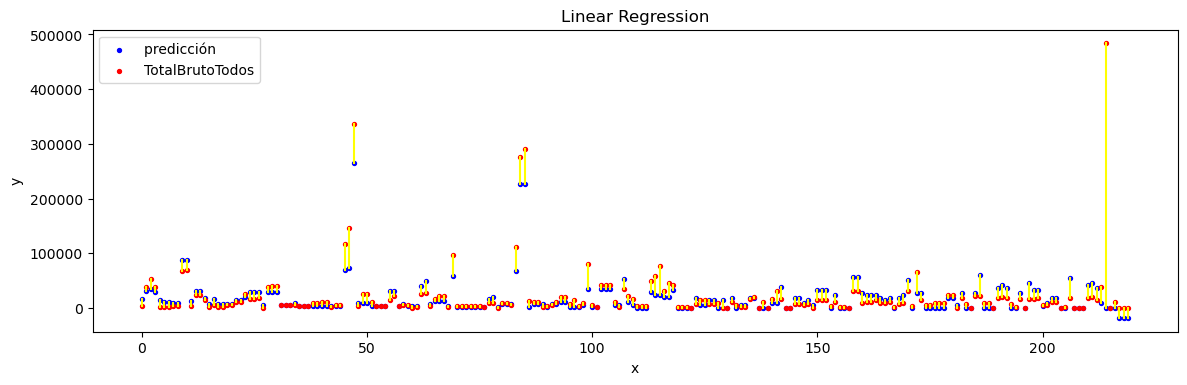

In [227]:
import matplotlib.pyplot as plt
%matplotlib inline

def scatter_pred_real(predictions,title):
    preds = predictions.toPandas()

    c4 = preds.TotalBrutoTodos
    c4_pred = preds.prediction
    x = list(range(len(c4)))

    plt.rcParams["font.size"] = 10
    figure, ax = plt.subplots(1, figsize=(14, 4), dpi=100)    
    for i in range(len(x)):
        plt.plot( [x[i],x[i]], [c4_pred[i], c4[i]], color="yellow")  # pinto líneas verticales de color amarillo

    plt.scatter(x, c4_pred, color='blue',  label="predicción ",s=8)
    plt.scatter(x, c4     , color='red', label="TotalBrutoTodos",s=8)


    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(title)
    plt.show()
    
scatter_pred_real(test_pred, 'Linear Regression')

Algo extraño pasa, especialmente si consideramos que las diferencias son muy grandes. Esto nos pasa por no hacer el histograma lo primero. Hagámoslo ahora:

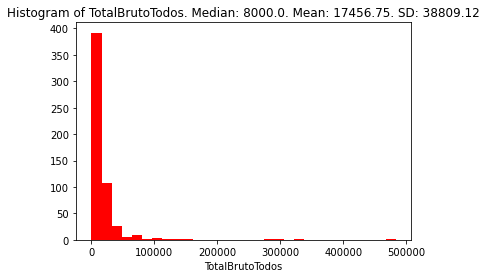

In [228]:
def histogram(df,col,bins=20,color="red"):
    fig,ax = plt.subplots()
    hist(ax, df.select([col]), bins = bins,  color=[color])
    plt.xlabel(col)
    # cálculo de media y desviación típica
    vs = df.select(f.mean(col),f.stddev(col)).collect()
    mean = vs[0][0]
    sd = vs[0][1]
    
    median = df.agg(f.percentile_approx(col, 0.5).alias("median")).collect()[0][0]

    
    plt.title("Histogram of "+str(col)+". Median: "+str(round(median,2))+". Mean: "+str(round(mean,2))+". SD: "+str(round(sd,2)))
    plt.show()
    
    
histogram(dataprep, 'TotalBrutoTodos', bins=30)

Es un caso clarísimo de outliers. 

## Preprocesamiento 2. Outliers

###  Eliminar outliers

Escribir código para modificar `dataprep` de forma que se eliminen todas las filas con `TotalBrutoTodos`  menor o igual a 0 mediante la función [filter](https://sparkbyexamples.com/pyspark/pyspark-where-filter/). El resultado se llamará `dataprep2`. 

Mostrar de nuevo el histograma.

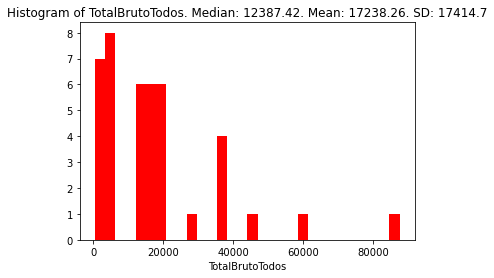

In [139]:
dataprep2 = dataprep.filter(dataprep['TotalBrutoTodos'] > 0)
histogram(dataprep2, 'TotalBrutoTodos', bins=30)

In [120]:
skewness = f.skewness(dataprep2['TotalBrutoTodos']).alias('skewness')
kurtosis = f.kurtosis(dataprep2['TotalBrutoTodos']).alias('kurtosis')
dataprep2.select(skewness, kurtosis).show()

+------------------+----------------+
|          skewness|        kurtosis|
+------------------+----------------+
|10.917971740947946|218.282845960066|
+------------------+----------------+



In [121]:
def try_regression(data, method):
    train, test = data.randomSplit([0.6, 0.4])
    model = method.fit(train)
    pred = model.transform(test)
    evaluator_rmse = RegressionEvaluator(predictionCol='prediction',
                                         labelCol='TotalBrutoTodos', metricName='rmse')
    rmse = evaluator_rmse.evaluate(pred)
    return rmse, pred

RMSE: 17483.919936118455


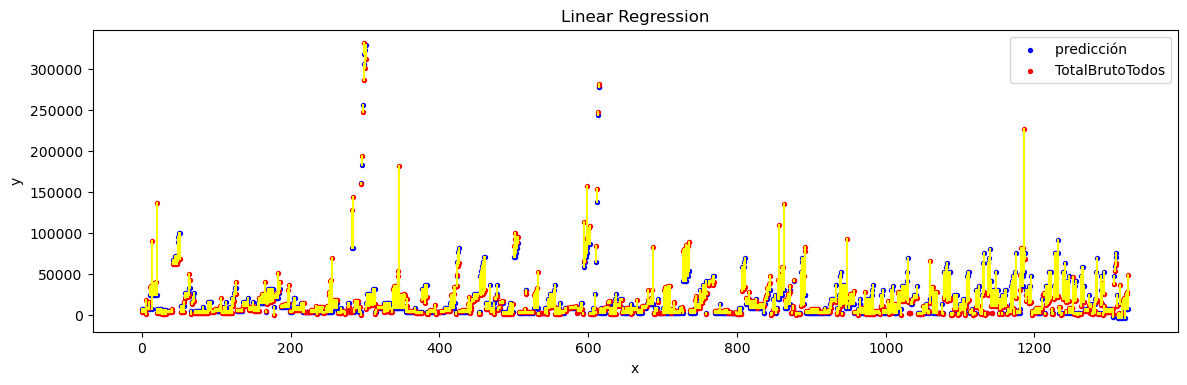

In [122]:
# Prueba de la función:
rmse, test_pred = try_regression(dataprep2,
    LinearRegression(featuresCol='features', labelCol='TotalBrutoTodos'))
print("RMSE:", rmse)
scatter_pred_real(test_pred, 'Linear Regression')

In [123]:
def repeat_regression(data, method, n):
    rmse_data = []
    pred = None
    for _ in range(n):
        rmse, pred = try_regression(data, method)
        rmse_data.append(rmse)
    mean_rsme = sum(rmse_data) / n
    return (mean_rsme, pred)

result = repeat_regression(dataprep2, LinearRegression(featuresCol='features',
                                                       labelCol='TotalBrutoTodos'), 10)
print("Resultado:", result)

Resultado: (27557.46738824001, DataFrame[features: vector, TotalBrutoTodos: double, prediction: double])


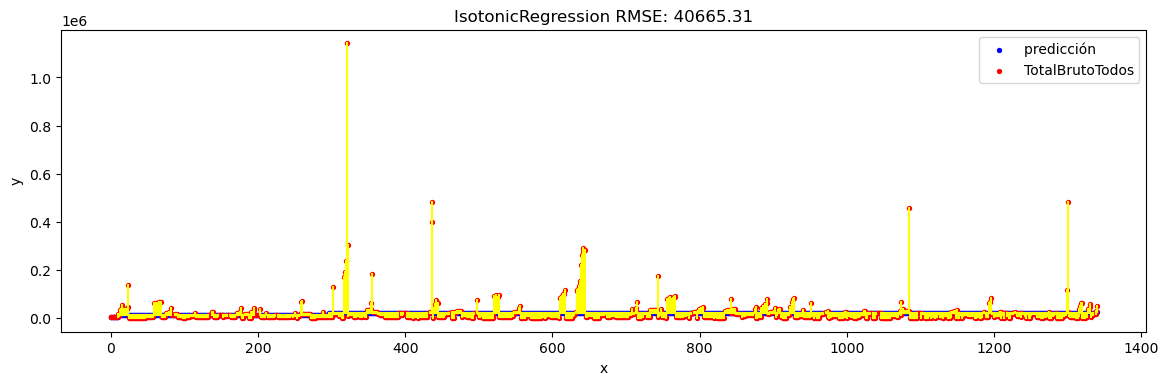

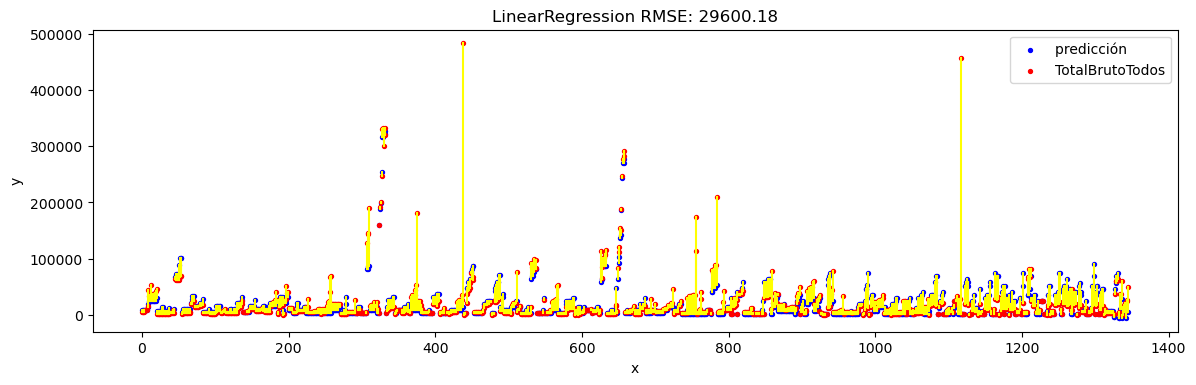

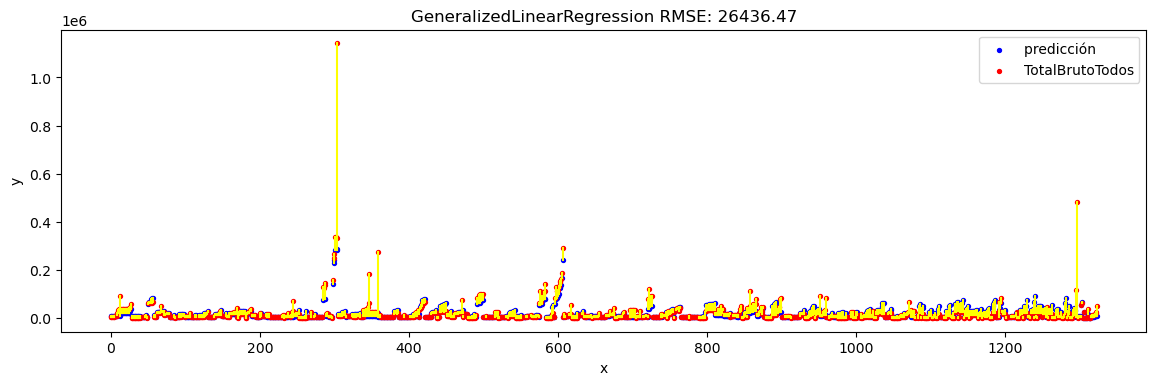

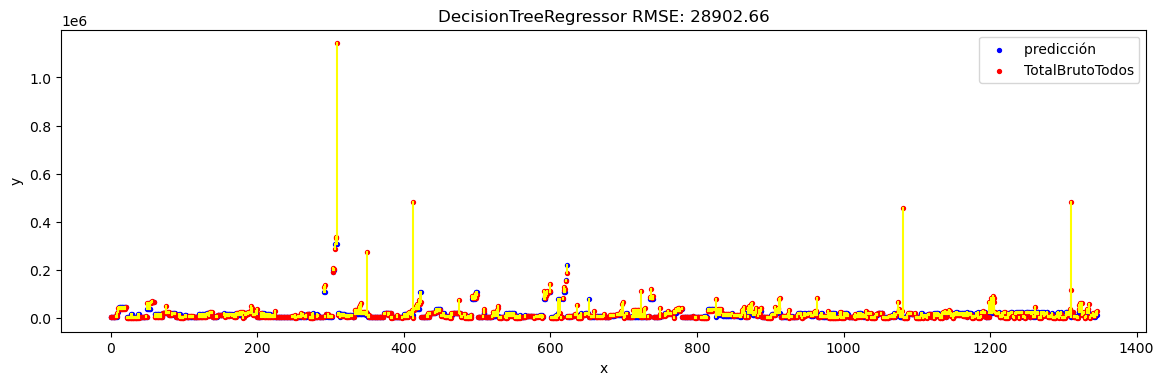

In [124]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import IsotonicRegression

methods = [
    ('IsotonicRegression', IsotonicRegression(featuresCol='features', labelCol='TotalBrutoTodos')),
    ("LinearRegression",LinearRegression(featuresCol='features', labelCol='TotalBrutoTodos')), 
    ('GeneralizedLinearRegression', GeneralizedLinearRegression(featuresCol='features', labelCol = 'TotalBrutoTodos')),
    ('DecisionTreeRegressor',DecisionTreeRegressor(featuresCol='features', labelCol='TotalBrutoTodos'))
]

for method in methods:
    result = repeat_regression(dataprep2, method[1], 10)
    scatter_pred_real(result[1], f"{method[0]} RMSE: {round(result[0], 2)}")
